# Normal likelihoods and normal-inverse-gamma priors

Today we explore how samples from a normal-inverse-gamma (NIG) distribution can be interpreted as normal distributions. Each sample from the NIG distribution specifies the mean and variance of a normal distribution.

This is related to the fact that the NIG distribution is a conjugate prior for the normal likelihood function. In fact, a sample from any conjugate prior can be interpreted as the likelihood function corresponding to that prior.

## Normal-inverse-gamma in SciPy

Even though SciPy does have classes defined for the normal distribution (`scipy.stats.norm`) and the inverse-gamma distribution (`scipy.stats.invgamma`), it does not have one defined for the normal-inverse-gamma distribution. To help you, the functions below implement the pdf and a sampler for the normal-inverse-gamma distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
'''
Function definitions for the normal-inverse-gamma distribution. The parameters
of the distribution, namely mu, lambda / nu, alpha, beta, are as defined here:

  https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution

Note that we use the symbol nu (ν) rather than lambda (λ) for the third parameter.
This is to match the notation used in the conjugate priors table on Wikipedia:

  https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions
'''

def norminvgamma_pdf(x, sigma2, mu, nu, alpha, beta):
    '''
    The probability density function of the normal-inverse-gamma distribution at
    x (mean) and sigma2 (variance).
    '''
    return (
        stats.norm.pdf(x, loc=mu, scale=np.sqrt(sigma2 / nu)) *
        stats.invgamma.pdf(sigma2, a=alpha, scale=beta))

def norminvgamma_rvs(mu, nu, alpha, beta, size=1):
    '''
    Generate n samples from the normal-inverse-gamma distribution. This function
    returns a (size x 2) matrix where each row contains a sample, (x, sigma2).
    '''
    sigma2 = stats.invgamma.rvs(a=alpha, scale=beta, size=size)  # Sample sigma^2 from the inverse-gamma
    x = stats.norm.rvs(loc=mu, scale=np.sqrt(sigma2 / nu), size=size)  # Sample x from the normal
    return np.vstack((x, sigma2)).transpose()

## Task 1

1. Generate 10 samples from the normal-inverse-gamma distribution with parameters as
   provided below. Each sample corresponds to the mean and variance of a normal
   distribution.
   
   With these hyperparameters the prior 95% confidence interval for
   the mean is about [-10, 10] and for the variance [0.1, 10]. In practice you would
   work the other way around: use confidence intervals to determine values for the
   prior hyperparameters.

2. Plot the 10 normal distributions corresponding to your 10 samples. To see the functions
   clearly, plot your graphs on the domain [-15, 15].
   
   You should see that the 10 samples
   (normal distributions) are all quite different. This means the prior is quite broad
   (uncertain) over the mean and variance.

In [4]:
# Normal-inverse-gamma prior hyperparameters
mu_0 = 0        # The prior mean is centered around 0.
nu_0 = 0.054    # The smaller nu_0 is, the more uncertain we are about the prior mean.
alpha_0 = 1.12  # alpha and beta govern the marginal prior over the variance.
beta_0 = 0.4

In [30]:
samples = (norminvgamma_rvs(mu=mu_0, nu=nu_0, alpha=alpha_0, beta=beta_0, size=10))
print (samples)

[[ 1.70833319  0.11873886]
 [-2.07870038  1.2841619 ]
 [ 4.26578741  0.49134734]
 [ 0.66242541  0.53635643]
 [ 7.30039839  8.05552217]
 [-3.69287084  2.69751179]
 [-3.55147029  0.58901244]
 [ 1.8391297   0.23344099]
 [ 1.54620202  0.31135981]
 [ 0.65017788  0.33138685]]


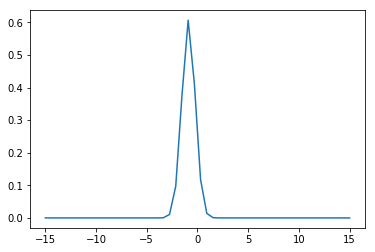

In [28]:
# Trying one distribution

x_0 = np.linspace(-15,15)
plt.plot(x_0, stats.norm.pdf(x=x_0, loc=samples[0][0], scale=(np.sqrt(samples[0][1]))))

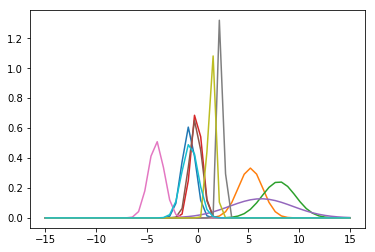

In [29]:
# 10 distributions

for i in range (0,len(samples)):
    plt.plot(x_0, stats.norm.pdf(x=x_0, loc=samples[i][0], scale=(np.sqrt(samples[i][1]))))

## Task 2

Draw 1,000,000 samples from the normal-inverse-gamma prior above and calculate
approximate 95% confidence intervals over the mean and the variance using the
samples. You can use the `numpy.percentile` function for this.

Your confidence intervals should approximately match the intervals [-10, 10] and [0.1, 10].

In [31]:
samples_1000 = (norminvgamma_rvs(mu=mu_0, nu=nu_0, alpha=alpha_0, beta=beta_0, size=1000))

In [41]:
means_1000 = []
for i in range(0,len(samples_1000)):
    means_1000.append(samples_1000[i][0])

variances_1000 = []
for i in range(0,len(samples_1000)):
    variances_1000.append(samples_1000[i][1])

print (np.percentile(means_1000, 2.5), np.percentile(means_1000, 97.5)) # 95% CI over mean
print (np.percentile(variances_1000, 2.5), np.percentile(variances_1000, 97.5)) # 95% CI over variance

-10.157381859614178 10.144699189769923
0.09787440704167254 11.07030809886224


## Task 3
Code the equations for calculating the posterior normal-inverse-gamma hyperparameters
from the prior hyperparameters and data.

In [ ]:
data = np.array([1, 2, 3, 4])  # In class you will get a larger data set.
                               # This is just to get you started.
n = len(data)
prior_mu = np.mean(means_1000)
prior_nu = 1000
sample_mean = np.mean(n)
prior_alpha = 1000/2
prior_beta = sum(np.sqrt(variances_1000))/2

mu_post = (prior_nu*prior_mu + n*sample_mean)/(prior_nu + n) # posterior mean
nu_post = prior_nu + n # number of old observ-s + the new number of observations 
alpha_post = prior_alpha + n/2 # where n is the number of new observations
beta_post = prior_beta + sum([(i-sample_mean)^2 for i in data])/2  + (n*1000/(1000+n))*((sample_mean-prior_mu)^2)/2